In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

PCA is fundamentally a dimensionality reduction algorithm, but it can also be useful as a tool for visualization, for noise filtering, for feature extraction and engineering, and much more.

PCA总结：

1.对于高维度数据，可以先从尝试PCA开始

2.PCA可以用于 降维 去噪 高维可视化的功能

3.PCA缺点： 受异常点影响较大  --- 因此有了 RandomizedPCA（速度快） 和 SparsePCA（加入了一个正则项保证成分的稀疏性）

# Intro to PCA

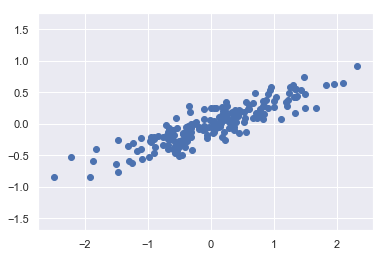

In [2]:
rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal');

By eye, it is clear that there is a nearly linear relationship between the x and y variables. This is reminiscent of the linear regression data we explored in In Depth: Linear Regression, but the problem setting here is slightly different: rather than attempting to predict the y values from the x values, the unsupervised learning problem attempts to learn about the relationship between the x and y values.

In principal component analysis, this relationship is quantified by finding a list of the principal axes in the data, and using those axes to describe the dataset. Using Scikit-Learn's PCA estimator, we can compute this as follows:

In [5]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [6]:
pca.components_

array([[-0.94446029, -0.32862557],
       [-0.32862557,  0.94446029]])

In [7]:
pca.explained_variance_

array([ 0.75871884,  0.01838551])

可视化一下：

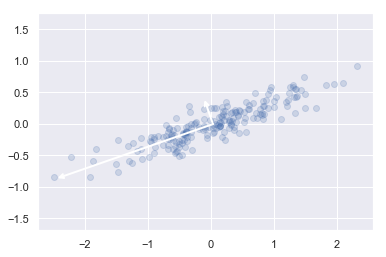

In [8]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal');

所谓pca.components即为向量的方向，pca.explained_variance即为向量的平方长度，即各个轴的“重要程度”

# 用PCA降维度

意味着：去除一个or多个最小主成分，从而得到更低维度且保留最大数据方差的数据投影（防止维度灾难）

In [9]:
#将刚才的二维数据投到一维上
pca = PCA(n_components =1)
pca.fit(X)
X_pca = pca.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

original shape:    (200, 2)
transformed shape: (200, 1)


(-2.77152878069022,
 2.661757596590677,
 -0.99646744326671266,
 1.0219081775900811)

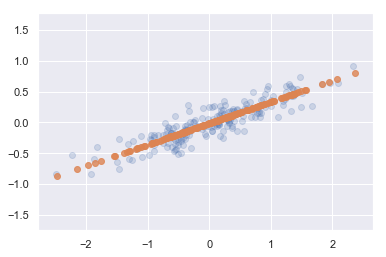

In [12]:
#PCA的逆变换
X_new = pca.inverse_transform(X_pca)
plt.scatter(X[:,0],X[:,1],alpha=0.2)
plt.scatter(X_new[:,0],X_new[:,1],alpha = 0.8)
plt.axis('equal')

可见与橙色线垂直的那一段被略去，可以理解为数据在降维后的信息损失量。虽然损失了一部分，但是总体关系仍然被保留下来，但是减少了一半的维度

# 用PCA作数据可视化： 手写数字

In [21]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

对于这种有64个维度的数据，想将其可视化似乎是不可能的，利用PCA降维后再去尝试可视化是一个方案

In [15]:
pca = PCA(n_components = 2)
projected = pca.fit_transform(digits.data)
print(projected.shape)


(1797, 2)


array([[ -1.25946915,  21.27488131],
       [  7.9576054 , -20.76870463],
       [  6.99193018,  -9.95598019],
       ..., 
       [ 10.80128344,  -6.96025129],
       [ -4.87208913,  12.42394767],
       [ -0.34438456,   6.36555434]])

c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\matplotlib\cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


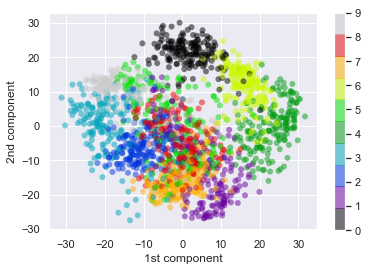

In [17]:
plt.scatter(projected[:,0],projected[:,1],c=digits.target,edgecolor = 'none',alpha = 0.5,cmap = plt.cm.get_cmap('spectral',10))
plt.xlabel('1st component')
plt.ylabel('2nd component')
plt.colorbar()

Recall what these components mean: the full data is a 64-dimensional point cloud, and these points are the projection of each data point along the directions with the largest variance. Essentially, we have found the optimal stretch and rotation in 64-dimensional space that allows us to see the layout of the digits in two dimensions, and have done this in an unsupervised manner—that is, without reference to the labels.

What do the components mean?
We can go a bit further here, and begin to ask what the reduced dimensions mean. This meaning can be understood in terms of combinations of basis vectors. For example, each image in the training set is defined by a collection of 64 pixel values, which we will call the vector $x$:

$$
x = [x_1, x_2, x_3 \cdots x_{64}]
$$
One way we can think about this is in terms of a pixel basis. That is, to construct the image, we multiply each element of the vector by the pixel it describes, and then add the results together to build the image:

$$
{\rm image}(x) = x_1 \cdot{\rm (pixel~1)} + x_2 \cdot{\rm (pixel~2)} + x_3 \cdot{\rm (pixel~3)} \cdots x_{64} \cdot{\rm (pixel~64)}
$$
One way we might imagine reducing the dimension of this data is to zero out all but a few of these basis vectors. For example, if we use only the first eight pixels, we get an eight-dimensional projection of the data, but it is not very reflective of the whole image: we've thrown out nearly 90% of the pixels!

figure source in Appendix

The upper row of panels shows the individual pixels, and the lower row shows the cumulative contribution of these pixels to the construction of the image. Using only eight of the pixel-basis components, we can only construct a small portion of the 64-pixel image. Were we to continue this sequence and use all 64 pixels, we would recover the original image.

But the pixel-wise representation is not the only choice of basis. We can also use other basis functions, which each contain some pre-defined contribution from each pixel, and write something like

$$
image(x) = {\rm mean} + x_1 \cdot{\rm (basis~1)} + x_2 \cdot{\rm (basis~2)} + x_3 \cdot{\rm (basis~3)} \cdots
$$
PCA can be thought of as a process of choosing optimal basis functions, such that adding together just the first few of them is enough to suitably reconstruct the bulk of the elements in the dataset. The principal components, which act as the low-dimensional representation of our data, are simply the coefficients that multiply each of the elements in this series. This figure shows a similar depiction of reconstructing this digit using the mean plus the first eight PCA basis functions:

figure source in Appendix

Unlike the pixel basis, the PCA basis allows us to recover the salient features of the input image with just a mean plus eight components! The amount of each pixel in each component is the corollary of the orientation of the vector in our two-dimensional example. This is the sense in which PCA provides a low-dimensional representation of the data: it discovers a set of basis functions that are more efficient than the native pixel-basis of the input data.

pca中成分数量参数的设定

我们可以将 累计方差贡献率 看作是成分数量的函数

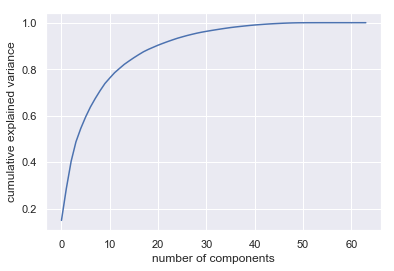

In [24]:

pca = PCA().fit(digits.data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

最多64个成分，投了等于没投lol。。。 大概选到20个主成分的时候就可以保留90%原始信息了

# 利用PCA作噪音过滤

PCA can also be used as a filtering approach for noisy data. The idea is this: any components with variance much larger than the effect of the noise should be relatively unaffected by the noise. So if you reconstruct the data using just the largest subset of principal components, you should be preferentially keeping the signal and throwing out the noise.

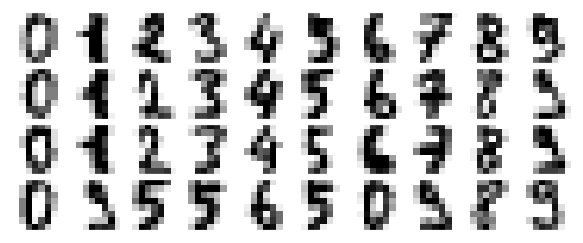

In [25]:
#无噪音图像
def plot_digits(data):
    fig, axes = plt.subplots(4, 10, figsize=(10, 4),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(8, 8),
                  cmap='binary', interpolation='nearest',
                  clim=(0, 16))
plot_digits(digits.data)

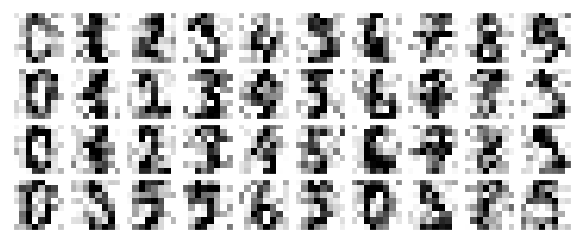

In [26]:
#加一些高斯白噪声的图像：
np.random.seed(42)
noisy = np.random.normal(digits.data, 4)
plot_digits(noisy)

In [37]:
#保留50%的原有信息
pca = PCA(0.50).fit(noisy)
pca.n_components_

12

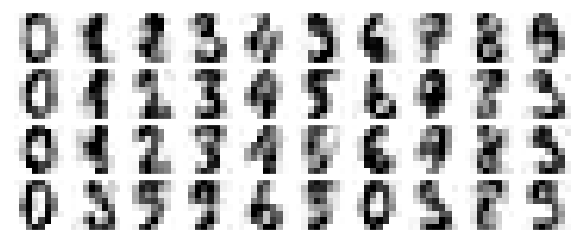

In [38]:
#将noisy data 投射到 12维
components = pca.transform(noisy)
#将投射后的noisy data 反向变形回到64维
filtered = pca.inverse_transform(components)

plot_digits(filtered)

肉眼可见的减少了很多噪音成分通过PCA方法

# PCA示例：特征脸

In [42]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:164: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:173: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:164: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:173: DeprecationWarning: `imresi

c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:164: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:173: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:164: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:173: DeprecationWarning: `imresi

c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:164: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:173: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:164: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:173: DeprecationWarning: `imresi

c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:164: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:173: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:164: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:173: DeprecationWarning: `imresi

c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:173: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:164: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:173: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:164: Depreca

c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:164: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:173: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:164: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:173: DeprecationWarning: `imresi

c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:164: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:173: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:164: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:173: DeprecationWarning: `imresi

c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:173: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:164: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:173: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:164: Depreca

c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:164: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:173: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:164: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:173: DeprecationWarning: `imresi

c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:164: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:173: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:164: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:173: DeprecationWarning: `imresi

c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:173: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:164: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:173: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:164: Depreca

c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:173: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:164: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:173: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:164: Depreca

c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:164: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:173: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:164: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:173: DeprecationWarning: `imresi

c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:164: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:173: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:164: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:173: DeprecationWarning: `imresi

c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:173: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:164: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:173: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:164: Depreca

c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:164: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:173: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:164: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:173: DeprecationWarning: `imresi

c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:164: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:173: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:164: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:173: DeprecationWarning: `imresi

c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:164: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:173: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:164: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:173: DeprecationWarning: `imresi

c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:173: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:164: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:173: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:164: Depreca

c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:173: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:164: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:173: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:164: Depreca

c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:164: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:173: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:164: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:173: DeprecationWarning: `imresi

c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:164: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:173: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:164: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:173: DeprecationWarning: `imresi

c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:164: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:173: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:164: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:173: DeprecationWarning: `imresi

c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:173: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:164: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:173: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:164: Depreca

c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:173: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:164: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:173: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:164: Depreca

c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:164: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:173: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:164: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:173: DeprecationWarning: `imresi

c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:173: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:164: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:173: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\lfw.py:164: Depreca

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


RandomizedPCA ----  比常规PCA更快，适用于高维度数据

前边几张感觉和光线有关，后边的慢慢开始反映出人脸上的一些特征（逐渐变态lol）

c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


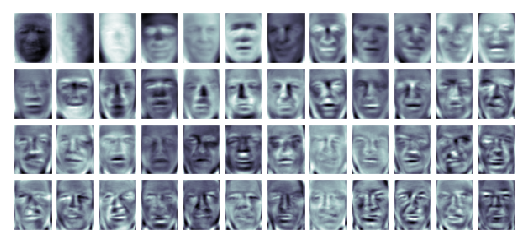

In [69]:
from sklearn.decomposition import RandomizedPCA
pca = RandomizedPCA(150)
pca.fit(faces.data)
fig, axes = plt.subplots(4, 12, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i ,ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(62,47),cmap='bone')


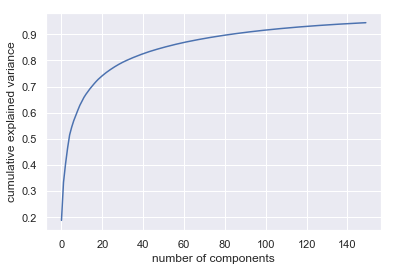

In [70]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


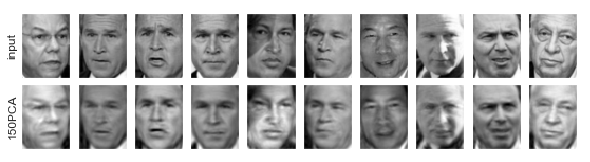

In [71]:
pca = RandomizedPCA(150).fit(faces.data)
components = pca.transform(faces.data)
projected = pca.inverse_transform(components)
# Plot the results
fig, ax = plt.subplots(2, 10, figsize=(10, 2.5),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(10):
    ax[0, i].imshow(faces.data[i].reshape(62, 47), cmap='binary_r')
    ax[1, i].imshow(projected[i].reshape(62, 47), cmap='binary_r')
    
ax[0, 0].set_ylabel('input')
ax[1, 0].set_ylabel('150PCA');

上图为 PCA 前后对比，再尝试一下50维的

c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


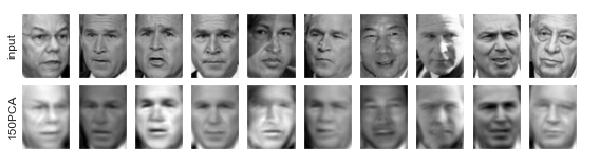

In [72]:
pca = RandomizedPCA(50).fit(faces.data)
components = pca.transform(faces.data)
projected = pca.inverse_transform(components)
# Plot the results
fig, ax = plt.subplots(2, 10, figsize=(10, 2.5),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(10):
    ax[0, i].imshow(faces.data[i].reshape(62, 47), cmap='binary_r')
    ax[1, i].imshow(projected[i].reshape(62, 47), cmap='binary_r')
    
ax[0, 0].set_ylabel('input')
ax[1, 0].set_ylabel('150PCA');